<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, I will use pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, I will demonstrate this by training with several different TF-Hub modules.

### Learning Objectives

By the time you complete this project, you will be able to:

- Use various pre-trained NLP text embedding models from TensorFlow Hub
- Perform transfer learning to fine-tune models on text data
- Visualize model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

## Task 2: Setting the Tensorflow and Colab Runtime.

In [49]:
import numpy as np
import pandas as pd
import os
import datetime
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Set up log directory
log_root_dir = "logs"
logdir = os.path.join(log_root_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Ensure the log directory exists
if not os.path.exists(logdir):
    os.makedirs(logdir)

  Preparing metadata (setup.py) ... done
Version:  2.15.0
Hub version:  0.16.1
GPU is available
  Preparing metadata (setup.py) ... done
Version:  2.15.0
Hub version:  0.16.1
GPU is available


##Downloading and Importing the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip).

In [7]:
df = pd.read_csv('Quora Data.csv')

In [8]:
df.shape

(33172, 3)

In [9]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


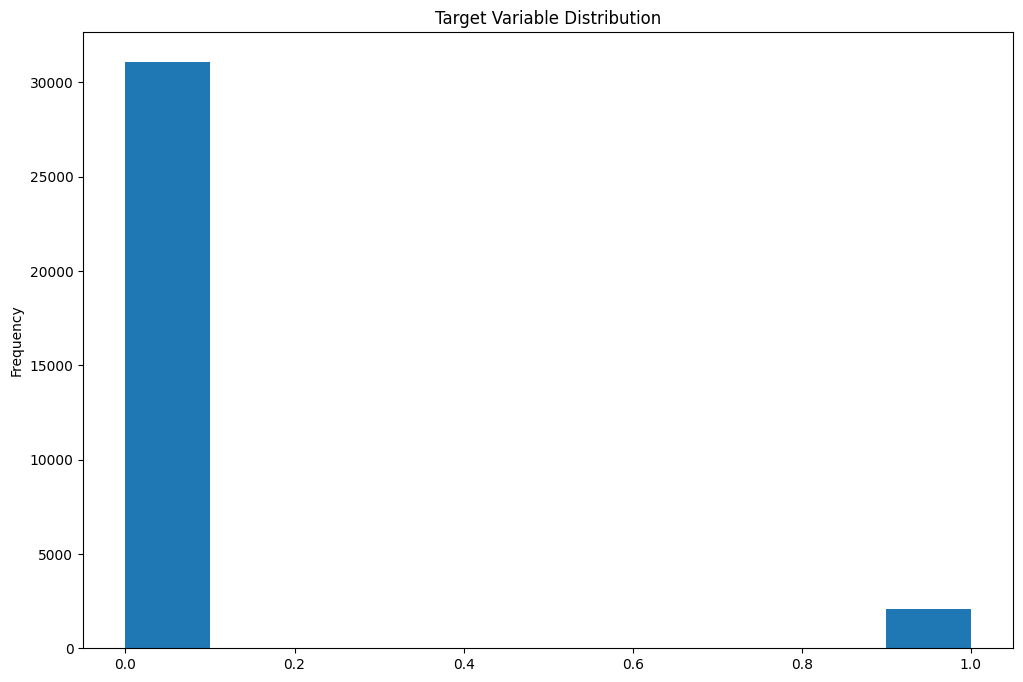

In [10]:
df['target'].plot(kind='hist', title='Target Variable Distribution');

In [11]:
df['target'].fillna(df['target'].mode()[0], inplace=True)

In [12]:
df['target'].isna().sum()

0

In [13]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state=35, train_size=0.4, stratify=df.target.values)
valid_df,_=train_test_split(remaining, random_state=35, train_size=0.08, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13268, 3), (1592, 3))

In [14]:
train_df.target.head(15)

29528    0.0
32037    0.0
26535    1.0
32818    0.0
24639    0.0
11757    0.0
17467    0.0
7858     0.0
25314    0.0
15898    0.0
13262    0.0
1181     0.0
24940    1.0
11126    0.0
2674     0.0
Name: target, dtype: float64

In [15]:
train_df.question_text.head(15).values

array(['What is the academic workload and pressure like at A.B. Lucas Secondary School?',
       'What are the possible ways to solve growth or expansion issues for a company?',
       'Why are Iranian/Persian women always so mean and shrewd? At our workplace here in Sweden they always seem to be a source of conflict and intrigues!',
       'How can you minimize your time spent on researching on the internet?',
       'What happens when I use electronic gadgets more than its has to be?',
       'How do Superman and Wonder Woman differ in morals?',
       'What does it feel like to fall down the London underground escalators?',
       'Is it true that reservations tickets booked using Paytm are not shown on reservation charting?',
       'I recently used custom domain name in my blog, but now whenever I submit URLs in Google webmaster then it shows, redirection, is there any one? Who knows how to change Blogspot to custom domain in Google webmaster?',
       'How did you feel when you f

## TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

We can think of a question vector as a distributed representation of a question, and is computed for every question in the training set. The question vector along with the output label is then used to train the statistical classification model.

The intuition is that the question vector captures the semantics of the question and, as a result, can be effectively used for classification.

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP:
* word-based representations and
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

In [44]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

##Defining Function to Build and Compile Models

In [17]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    # Define the hub layer with the given module URL and parameters
    hub_layer = hub.KerasLayer(module_url, output_shape=[embed_size],
                               input_shape=[], dtype=tf.string, trainable=trainable)

    # Build the model
    model = tf.keras.models.Sequential([
        hub_layer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

    # Print the model summary
    model.summary()

    # Train the model
    history = model.fit(
        train_df['question_text'], train_df['target'],
        epochs=100,
        batch_size=32,
        validation_data=(valid_df['question_text'], valid_df['target']),
        callbacks=[
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
            tf.keras.callbacks.TensorBoard(log_dir=name)
        ],
        verbose=0
    )

    return history

## Training Various Text Classification Models

In [18]:
histories ={}

In [29]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [31]:
histories['universal-sentence-encoder -finetuned'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder - finetuned',
                                                                    trainable=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256945665 (980.17 MB)
Trainable params: 256945665 (980.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.9328,  loss:0.2359,  val_accuracy:0.9485,  val_loss:0.1440,  
....

##Compare Accuracy and Loss Curves

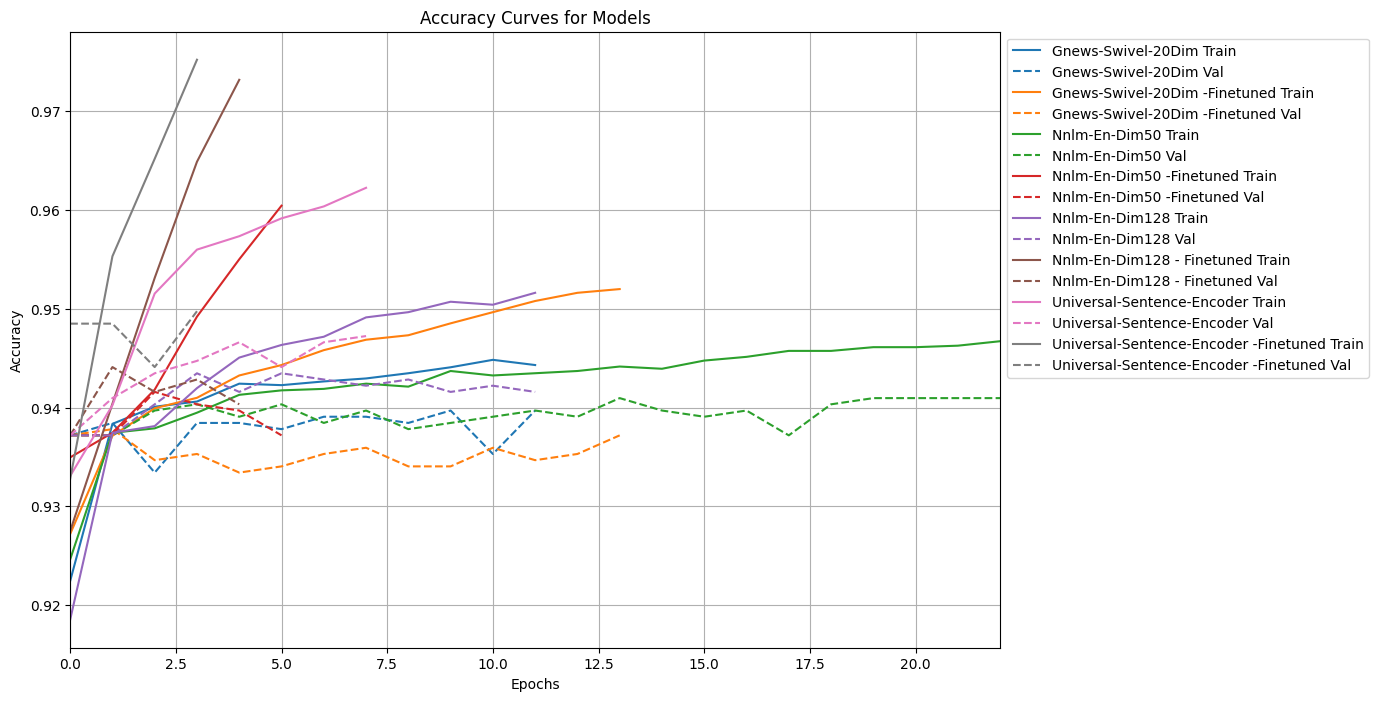

In [32]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

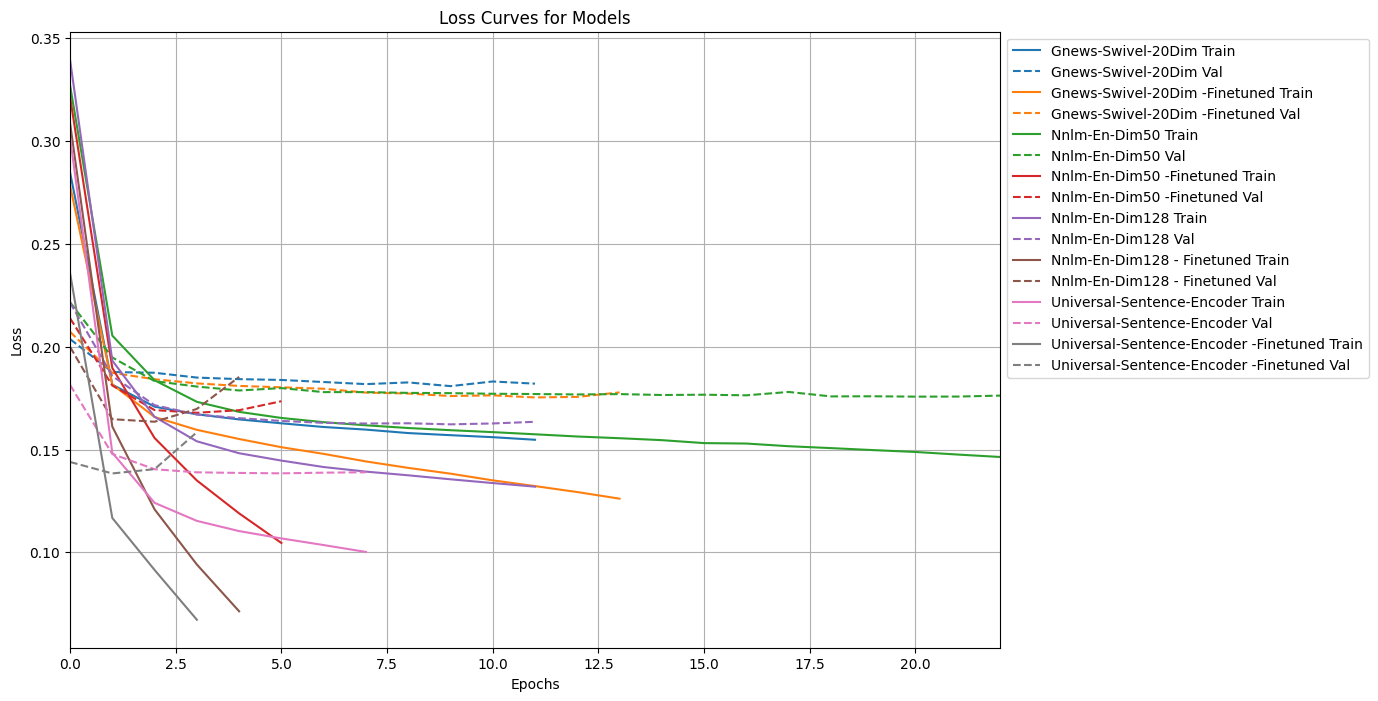

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 9: Fine-tune Model from TF Hub

##Train Bigger Models and Visualize Metrics with TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir}